<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#switch-Class-Definition" data-toc-modified-id="switch-Class-Definition-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><code>switch</code> Class Definition</a></span></li><li><span><a href="#hashQobj-class-definition" data-toc-modified-id="hashQobj-class-definition-2"><span class="toc-item-num">2&nbsp;&nbsp;</span><code>hashQobj</code> class definition</a></span></li><li><span><a href="#qutipLattice-Class-Definition" data-toc-modified-id="qutipLattice-Class-Definition-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><code>qutipLattice</code> Class Definition</a></span></li><li><span><a href="#qutipHamiltonian-Class-Definition" data-toc-modified-id="qutipHamiltonian-Class-Definition-4"><span class="toc-item-num">4&nbsp;&nbsp;</span><code>qutipHamiltonian</code> Class Definition</a></span><ul class="toc-item"><li><span><a href="#Test-to-Verify-getDeltaEnergy-Work-as-Advt." data-toc-modified-id="Test-to-Verify-getDeltaEnergy-Work-as-Advt.-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Test to Verify <code>getDeltaEnergy</code> Work as Advt.</a></span></li><li><span><a href="#Simulated-Annealing-Algorithm" data-toc-modified-id="Simulated-Annealing-Algorithm-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Simulated Annealing Algorithm</a></span></li></ul></li></ul></div>

In [1]:
import networkx as nx
import numpy as np
import matplotlib as matplotlib
matplotlib.use('qt5agg')

In [ ]:
import matplotlib.pyplot as plt
import random

from qutip import *

In [ ]:
matplotlib.get_backend()

In [ ]:
%matplotlib inline

# `switch` Class Definition

Reference: [ActiveState Recipes](http://code.activestate.com/recipes/410692/)

Example Usage:

The following example is pretty much the exact use-case of a dictionary, but is included for its simplicity. Note that you can include statements in each suite.
    
```
v = 'ten'
for case in switch(v):
    if case('one'):
        print 1
        break
    if case('two'):
        print 2
        break
    if case('ten'):
        print 10
        break
    if case('eleven'):
        print 11
        break
    if case(): # default, could also just omit condition or 'if True'
        print "something else!"
        # No need to break here, it'll stop anyway
```

In [ ]:
# This class provides the functionality we want. You only need to look at
# this if you want to know how this works. It only needs to be defined
# once, no need to muck around with its internals.
class switch(object):
    def __init__(self, value):
        self.value = value
        self.fall = False

    def __iter__(self):
        """Return the match method once, then stop"""
        yield self.match
        raise StopIteration
    
    def match(self, *args):
        """Indicate whether or not to enter a case suite"""
        if self.fall or not args:
            return True
        elif self.value in args: # changed for v1.5, see below
            self.fall = True
            return True
        else:
            return False

# `hashQobj` class definition

In [ ]:
class hashQobj(Qobj):
    
    def __hash__(self):
        return hash(repr(self))

# `qutipLattice` Class Definition

In [ ]:
class qutipLattice():
    
    hamiltonian = None
    
    hamOp = Qobj()
    
    fieldOp = Qobj()
    
    graph = nx.empty_graph(0)
#     size = 10
    state_dims = 2
    state = np.empty([]) # create empty array
    colors = ['r','b','g','c','m','y','k','w']
    node_color_map = {}
    edge_color_map = {}
#     upspin = hashQobj(basis(2,0))
#     dnspin = hashQobj(basis(2,1))
#     color_map = {upspin:'r', dnspin :'b'}
    state_values = []    # elements are hashQobj objects which are all possible states of a node allowed for particular model
    node_color_dict = {} # dictionary whose keys are nodes and values are colors for each node
    node_colors = []
    pos_dict = {}
    
    edge_color_dict = {} # dictionary whose keys are edges and values are colors for each edge
    edge_colors = []
    
    lattice_dims = [10]      # by default lattice dimension is 1d with 10 sites,
                             # in general will be list [x,y,z,...], indicating
                             # size of lattice along each dimension
    dimension = 1                 # dimensionality of lattice, by default 1d
    
    use_default_vars = True
    
    scale_mult = []
    
    node_size = 100
    
    node_ext_field_on = False     # flag to determine whether or not an external field is present
    
    history_size = 100       # number of instances of past results to store 
    
    history_latt_energy = []        # array to store the previously calculated values of the lattice energy
    
    history_node_energy = {}        # dict to store nodes whose energy was last calculated and the calculated energies
    
    
    
    def __init__(self,lattice_dims=[10],periodic=False,hamType=None,hamVars=None):
        
        if isinstance(lattice_dims,list) and len(lattice_dims)>0 and all(isinstance(i,int) for i in lattice_dims):
            self.lattice_dims = lattice_dims
            self.dimension = len(lattice_dims)
        else:
            raise ValueError('lattice_dim should be non-empty list of positive integers')
        
#         self.size = size
        
#         self.graph = nx.grid_2d_graph(size,size,periodic=periodic)

        self.graph = nx.grid_graph(self.lattice_dims,periodic=periodic)
        
        for i in self.lattice_dims:
            self.scale_mult.append(10.0/i)   # what does this do ???
        
        if self.dimension == 1:
            for node in self.graph:
                self.pos_dict[node] = [self.scale_mult[0]*node,0]
        else:
            print("Dimension of Lattice: ", self.dimension)
            for node in self.graph:
                # set the node co-ordinates to be same as node indices
                self.pos_dict[node] = [self.scale_mult[i]*node[i] for i in range(self.dimension)]
                
                # set 'flipped' attribute of each node to False
                self.graph.node[node]['flipped'] = False

        
        if hamType:
            self.hamiltonian = qutipHamiltonian(hamType,self.graph,hamVars)
            self.hamOp = self.hamiltonian.hamOp
            self.fieldOp = self.hamiltonian.fieldOp
            self.state_dims = self.hamiltonian.state_dims
            self.state_values = [hashQobj(basis(self.state_dims,i)) for i in range(self.state_dims)] # Possible states of a given site
            print(self.state_values)
            for i in range(self.state_dims):
                self.node_color_map[self.state_values[i]] = self.colors[i]
            self.setRandomState()
    
    def setRandomState(self):
        '''Iterates over all nodes in the graph. For each node, creates an attribute
        labeled 'state', and assigns to it at random QuTiP objects returned by basis(2,0) or basis(2,1)
        corresponding to spin up or spin down.'''

        for node in self.graph:
            self.graph.node[node]['state'] = self.state_values[np.random.randint(self.state_dims)]
            self.updateNodeColor(node)
        
        return

    def updateNodeColor(self,node):
        self.node_color_dict[node] = self.node_color_map[self.graph.node[node]['state']]
    
    def setRandomField(self,ranges=[-1.0,1.0]):
        '''Iterates over all nodes in the graph. For each node, creates an attribute
        labeled 'field', and assigns to it at random a value between the limits specified by the first
        elements of the list passed in the first argument'''
        
        if not(isinstance(ranges,list)):
            raise ValueError('Argument `ranges` must be of list type')
        elif len(ranges)!=2 or not(all(isinstance(i,float) for i in ranges)):
            raise ValueError('Argument `ranges` must have exactly two elements of type float')
        else:
            self.node_ext_field_on = True
            upper = max(ranges)
            lower = min(ranges)
            delta = upper - lower
            for node in self.graph:
                self.graph.node[node]['field'] = delta * np.random.random_sample() + lower
    
    def setExternalField(self,field=None):
        '''Sets the external field at each lattice site. The argument `field` is a dictionary whose
        keys are nodes and values are the values of the field at each node. These values are
        assigned to a new node attribute called `field`. '''
        
        if field==None or len(field)==0:
            print('Fields not specified. Setting field at each node to zero.')
            return
        else:
            print('Setting external field')
            
            self.node_ext_field_on = True
            
            def_field_nodes = set(field.keys())
            all_nodes = set(self.graph.nodes())
            if (def_field_nodes < all_nodes):
                undef_field_nodes = all_nodes - def_field_nodes
            elif (def_field_nodes > all_nodes):
                raise ValueError('Specified nodes are not present in lattice')
                
            for node in field.keys():
                self.graph.node[node]['field'] = float(field[k])
            for node in undef_field_nodes:
                self.graph.node[node]['field'] = 0.0
        return

    def fieldEnergy(self,node):
        if self.node_ext_field_on:
            energy = 0.
            energy += expect(self.fieldOp,self.graph.node[node]['field']*self.graph.node[node]['state'])
            return energy
    
    def nearestEnergy(self,node):
        energy = 0.
        for neighbor in self.graph[node]:
            tempstate = tensor(self.graph.node[node]['state'],self.graph.node[neighbor]['state'])
            energy += expect(self.hamOp,tempstate)
        return energy
    
    def nextNearestEnergy(self,node):
        energy = 0.
        for nearest in self.graph[node]:
            for nextnearest in self.graph[nearest]:
                if nextnearest!=node:
                    tempstate = tensor(self.graph.node[node]['state'],self.graph.node[nextnearest]['state'])
                    energy += expect(self.hamOp,tempstate)
        return energy
    
    def getNodeRandomState(self,node):
        '''Function to get a state of the specified node different from the present state'''
        old_state = self.graph.node[node]['state']
        new_state = old_state
        
        while (new_state == old_state):  # iterate until we obtain a state different from the original one.
            new_state = self.state_values[np.random.randint(self.state_dims)]
            
#         self.setNodeState(node,new_state)
        
        return new_state
    
    
    def setNodeState(self,node,state_f):
        
        state_i = self.graph.node[node]['state']
        
        self.graph.node[node]['state'] = state_f
        self.updateNodeColor(node)
        
        return state_i
        
        
    def getRandomNode(self):
        '''Select and return a node from the lattice at random.'''
        return random.choice(self.graph.nodes())
    
    def latticeEnergy(self):
        energy = 0
        if self.node_ext_field_on:
            for node in self.graph:
                energy = energy + self.nearestEnergy(node) + self.fieldEnergy(node)
        else:
            for node in self.graph.nodes():
                energy = energy + self.nearestEnergy(node)
        return energy
    
    def getRandomState(self):
        '''Returns random state from allowed values'''
        return self.state_values[np.random.randint(self.state_dims)]
    
    def getDeltaEnergy(self,node,state_f):
        '''Function to calculate the change in the lattice energy due to changing the state of the given node.
        
        Parameters
        ----------
        
        node:  node for which state is to changed
        
        state_f: hashQobj object corresponding to state given node should be set to
        '''        
        state_i = self.graph.node[node]['state']
        
        # if the new state is the same as old state, then the energy will not change
        if (state_f == state_i):
            return 0.

        energy_i = 0.
        energy_f = 0.

        energy_i += self.nearestEnergy(node)
        for neighbor in self.graph[node]:
            energy_i += self.nearestEnergy(neighbor)
        
        self.graph.node[node]['state'] = state_f
        
        energy_f += self.nearestEnergy(node)
        for neighbor in self.graph[node]:
            energy_f += self.nearestEnergy(neighbor)
            
        if self.node_ext_field_on == True:
            energy_i += expect(self.fieldOp,self.graph.node[node]['field']*state_i)
            energy_f += expect(self.fieldOp,self.graph.node[node]['field']*state_f)
        
        self.graph.node[node]['state'] = state_i
        
        return (energy_f - energy_i)
    
    def getDeltaEnergySimple(self,node,state_f):
        
        state_i = self.graph.node[node]['state']
        
        # if the new state is the same as old state, then the energy will not change
        if (state_f == state_i):
            return 0.

        energy_i = self.latticeEnergy()
        self.graph.node[node]['state'] = state_f
    
        energy_f = self.latticeEnergy()
        self.graph.node[node]['state'] = state_i
        
        return (energy_f - energy_i)

    
    def draw(self):
        self.node_colors = list(self.node_color_dict.values())
        nx.draw(self.graph,pos=self.pos_dict,node_color=self.node_colors,node_size=self.node_size)
                

In [8]:
nx.graph?

# `qutipHamiltonian` Class Definition

In [11]:
class qutipHamiltonian():
    '''Class which defines the hamiltonian acting on a given site of a lattice'''
    
    hamTypes = ['NumberOp', 'Ising', 'Heisenberg','Hubbard', 'AKLT', 'SpinGlass']
    
    defaultVars = {'NumberOp':   {'J':1, 'dims': 2},
                   'Ising':      {'J': 1, 'mu': 0},
                   'Heisenberg': {'J': 1, 'mu': 0, 'dims': 3},
                   'Hubbard':    {'J': 1, 'U': 0, 'mu': 1},
                   'SpinGlass':  {'J_ij': [[]], 'mu': 0},
                   'AKLT':       {'J': 1}
              }             # default values of Hamiltonian parameters
    
    hamType = None          # type of Hamiltonian: Ising, Heisenberg, Hubbard etc.
    
    hamOp = Qobj()          # single-site Hamiltonian operator
    
    fieldOp = Qobj()
    
    hamVars = {}            # parameters necessary for defining Hamiltonian, coupling strengths, etc.
    
    graph = None            # graph on which Hamiltonian is defined.
    
    state_dims = 2                # dimension of single particle Hilbert space.
    
    latticeDimension = 2    # dimension of lattice on which Hamiltonian is defined.

    latticeSize = (5,5)     # tuple containing number of sites in lattice, should match latticeDimension.
    
    def __init__(self, hamType, graph=None, hamVars=None):
        
        if hamType != None:
            if hamType not in self.hamTypes:
                raise ValueError('hamType must be one of ',self.hamTypes)
            else:
                self.hamType = hamType
                self.initHamiltonian(graph,hamType,hamVars)
                
    def initHamiltonian(self,graph,hamType,hamVars):
        
        if graph!=None:
            self.graph = graph
        else:
            print('Lattice is not defined.')
        
        defVars = self.defaultVars.get(hamType)
        
        print(defVars)
        
        if hamVars:
            if set(hamVars.keys()).issubset(set(defVars.keys())):
                self.setHamiltonianVars(hamType,hamVars)
                self.setHamiltonianOp(hamType)
                print(self.hamVars)
            else:
                raise ValueError('Hamiltonian variables for', self.hamType, 'model, should subset of:'\
                                            ,defVars)
        else:
            print('Hamiltonian parameters not specified. Using default values')
            self.setHamiltonianVars(hamType,defVars)
            self.setHamiltonianOp(hamType)
            print(self.hamVars)
            
        return
    
    def setHamiltonianVars(self,hamType,hamVars):

        self.hamVars = self.defaultVars.get(hamType)
        for k in hamVars.keys():
            self.hamVars[k] = hamVars[k]    

        for case in switch(hamType):
            if case('Ising'):
                print('Ising')
                self.J = self.hamVars['J']
                self.mu = self.hamVars['mu']
                break

            if case('Hubbard'):
                print('Hubbard')
                self.J = self.hamVars['J']
                self.mu = self.hamVars['mu']
                self.U = self.hamVars['U']
                break
                
            if case('Heisenberg'):
                print('Heisenberg')
                self.J = self.hamVars['J']
                self.mu = self.hamVars['mu']
                self.state_dims = 3     # Heisenberg spin-chain has spin 1 particles
                break
            
            if case('AKLT'):
                print('AKLT')
                self.J = self.hamVars['J']
                
#             if case('SpinGlass'):
#                 if hamVars:
#                     self.J_ij = hamVars['J_ij']
#                     self.mu = hamVars['mu']
#                 else:
#                     self.J = 1
#                     self.h = 0
#                     self.mu = 0
#                 break
                
            if case('NumberOp'):
                break
            
            return

    def getHamiltonianVars(self):
        if self.hamVars == {}:
            print("Hamiltonian variables not defined")
        else:
            for k in self.hamVars.keys():
                print(k,self.hamVars[k])
        
    def setHamiltonianOp(self,hamType):
        if self.hamVars.get('dims'):
            self.state_dims = self.hamVars['dims']
        else:
            self.state_dims = 2

        dim = self.state_dims
        j = (dim-1)/2.0
        
        sx = jmat(j,'x')
        sy = jmat(j,'y')
        sz = jmat(j,'z')
        sp = jmat(j,'+')
        sm = jmat(j,'-')
        identity = qeye(dim)
        
        self.fieldOp = sz
        
        for case in switch(hamType):
            if case('Ising'):
                self.hamOp = -self.J * tensor(sz,sz)
                break
            
            if case('AKLT'):
                self.hamOp = -self.J * (tensor(sx,sx) + tensor(sy,sy) + tensor(sz,sz))
                self.hamOp += -self.J/3.0 * (tensor(sx,sx) + tensor(sy,sy) + tensor(sz,sz))**2
            
            if case('Hubbard'):
                break
                
            if case('Heisenberg'):
                self.hamOp = -0.5*self.J * (tensor(sp,sm) + tensor(sm,sp))
                self.hamOp += -self.J * tensor(sz,sz)
                break
                
#             if case('SpinGlass'):
#                 if hamVars:
#                     self.J_ij = hamVars['J_ij']
#                     self.mu = hamVars['mu']
#                 else:
#                     self.J = 1
#                     self.h = 0
#                     self.mu = 0
#                 break
                
            if case('NumberOp'):
                break        
            
            return
    
    @property
    def hermitian(self):
        return self._isHermitian
    
    @hermitian.setter
    def hermitian(self, value):
        if isinstance(value, bool):
            self._isHermitian = value
        else:
            raise ValueError('hermitian must be a boolean data type')

In [12]:
latt = qutipLattice(lattice_dims=[10],hamType='Heisenberg',periodic=False,hamVars={'mu': 0.1, 'J': 1})

{'J': 1, 'mu': 0, 'dims': 3}
Heisenberg
{'J': 1, 'mu': 0.1, 'dims': 3}
[Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[ 1.]
 [ 0.]
 [ 0.]], Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[ 0.]
 [ 1.]
 [ 0.]], Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[ 0.]
 [ 0.]
 [ 1.]]]


## Test to Verify `getDeltaEnergy` Work as Advt.

In [13]:
for i in range(10):
    node = latt.getRandomNode()
    state_f = latt.getNodeRandomState(node)
    delta_e1= latt.getDeltaEnergy(node,state_f)
    delta_e2 = latt.getDeltaEnergySimple(node,state_f)
    print(delta_e1,delta_e2)

TypeError: unhashable type: 'dict'

In [14]:
latt.graph.node[9]

{'state': Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
 Qobj data =
 [[ 0.]
  [ 0.]
  [ 1.]]}

In [16]:
type(_14)

dict

In [17]:
for node in latt.graph.nodes():
    print(type(node))
    print(node)

<class 'int'>
0
<class 'int'>
1
<class 'int'>
2
<class 'int'>
3
<class 'int'>
4
<class 'int'>
5
<class 'int'>
6
<class 'int'>
7
<class 'int'>
8
<class 'int'>
9


In [18]:
latt.setRandomField()

In [19]:
latt.hamiltonian.getHamiltonianVars()

J 1
mu 0.1
dims 3


In [20]:
latt.setRandomState()

## Simulated Annealing Algorithm

For finding ground state.

In [21]:
pos_delta_e = 0
neg_delta_e = 0
temp = 200.
for i in range(2000):
    node = latt.getRandomNode()
    if latt.graph.node[node]['flipped']==False:
        state_f = latt.getNodeRandomState(node)
        delta_e = latt.getDeltaEnergy(node,state_f)
#         delta_e = latt.getDeltaEnergySimple(node,state_f)
#         print(delta_e)
        if delta_e < 0:
            latt.setNodeState(node,state_f)
            latt.graph.node[node]['flipped'] = True
            neg_delta_e += delta_e
            print(i,node,delta_e,neg_delta_e)
        elif delta_e > 0 and np.exp(-delta_e/(temp/(i+1))) > np.random.random_sample():
            latt.setNodeState(node,state_f)
            latt.graph.node[node]['flipped'] = True
            pos_delta_e += delta_e
            print(i,node,delta_e,pos_delta_e)
    elif latt.graph.node[node]['flipped']==True:
#         latt.setNodeRandomState(node)
        latt.graph.node[node]['flipped'] = False
print('Net positive change: ',pos_delta_e)
print('Net negative change: ',neg_delta_e)
print('Net change: ',pos_delta_e+neg_delta_e)

TypeError: unhashable type: 'dict'

In [23]:
print("%3s \t %8s \t %4s \t %4s" % (i,node,delta_e,neg_delta_e))

NameError: name 'delta_e' is not defined

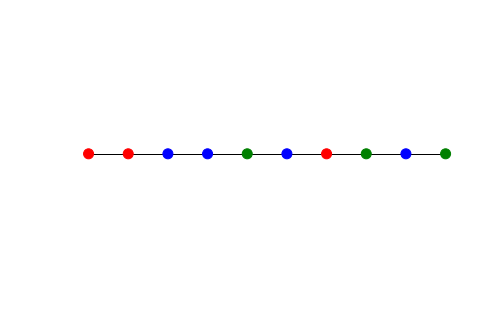

In [22]:
latt.draw()

In [24]:
latt.latticeEnergy()

0.8111528146916753

In [25]:
latt.getRandomState()

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[ 0.]
 [ 0.]
 [ 1.]]

In [26]:
import random

In [27]:
latt.getRandomNode()

{'field': -0.904540758564061,
 'state': Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
 Qobj data =
 [[ 0.]
  [ 0.]
  [ 1.]]}

In [28]:
latt.getDeltaEnergy(latt.getRandomNode(),latt.getRandomState())

TypeError: unhashable type: 'dict'

In [29]:
latt.setRandomState()

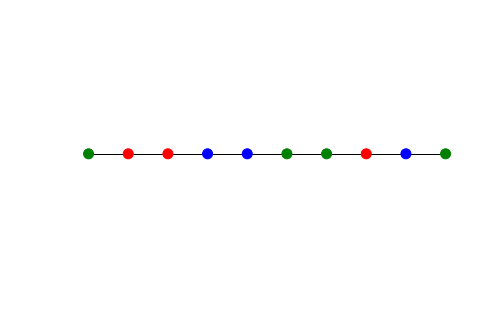

In [30]:
latt.draw()

In [31]:
%timeit(latt.latticeEnergy())

7.13 ms ± 849 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
latt.setRandomField()

In [33]:
latt.latticeEnergy()

-1.2126198640142225

In [34]:
for node in latt.graph:
    print(latt.graph.node[node]['field'])

-0.4943057937820807
-0.16821178286065508
-0.1258683199845536
-0.10409065631843606
-0.1517316382722691
-0.4863107500869186
0.8361661345733915
0.3852219956304641
0.2869335565785105
0.4744931187873991


In [35]:
latt.hamiltonian.hamOp

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[-1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0. -1.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.]]

In [36]:
energies = []
for i in range(100):
    latt.setRandomState()
    energies.append(latt.latticeEnergy())

(array([  3.,   4.,  12.,  25.,  24.,  16.,  13.,   1.,   0.,   2.]),
 array([-11.05459276,  -8.47078379,  -5.88697483,  -3.30316587,
         -0.71935691,   1.86445206,   4.44826102,   7.03206998,
          9.61587894,  12.1996879 ,  14.78349687]),
 <a list of 10 Patch objects>)

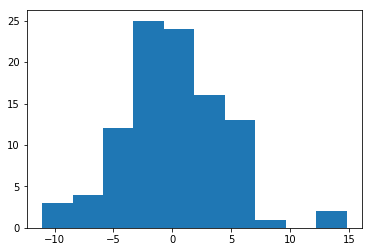

In [37]:
plt.hist(energies,bins=10)

(<matplotlib.figure.Figure at 0x11a7bc1d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11a5a0d30>)

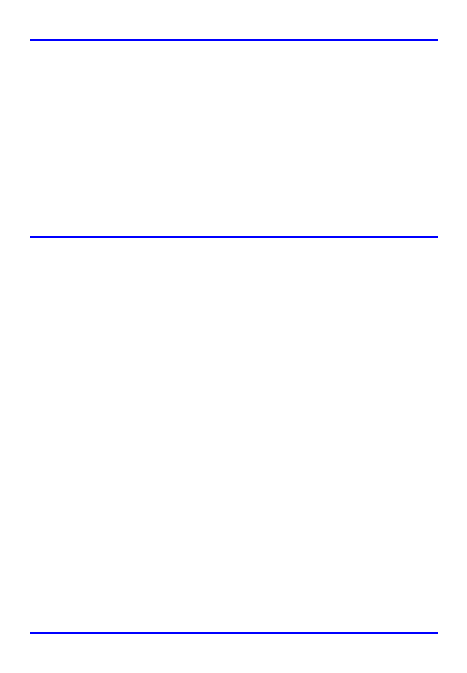

In [38]:
plot_energy_levels([latt.hamOp])

In [39]:
uniq_energies = set(energies)
print(sorted(uniq_energies))

[-11.054592755101782, -9.52271776986059, -8.928826913625514, -7.233463882173358, -7.002312917038484, -6.781623087948855, -6.469939884319485, -5.297932478154746, -5.1160183487239355, -5.020280737372304, -4.967757238944384, -4.252319998486548, -4.0617779899740984, -3.886496353612101, -3.840270569348262, -3.7765681871002124, -3.675287392976456, -3.647313633673516, -3.6037913918184654, -3.138217732994473, -3.101485893020362, -2.832951993080487, -2.800864394379972, -2.716835929065318, -2.59189939883766, -2.4951246515076333, -2.2530643549651024, -2.1312534226003117, -2.1163357492613994, -2.0648209923333334, -1.9542775180530134, -1.9510218416424003, -1.9117569853687428, -1.7939512595077367, -1.7326183110413924, -1.6367409773891943, -1.5964821071050728, -1.3533238665186242, -1.218398680249429, -1.1758353982275855, -1.1382429967626029, -1.1014952142288519, -1.081788388902849, -0.9800761340255308, -0.4844504902146843, -0.37023127477196954, -0.35329371686674266, -0.3155794023812594, -0.0834923980

In [40]:
energy_count = {}
for uniq in uniq_energies:
    energy_count[uniq] = energies.count(uniq)
print(energy_count)

{-0.9800761340255308: 1, 1.4408625480529729: 1, 1.8359134310072: 1, 3.2219130340065063: 1, 4.68159427565313: 1, 0.44542446274631: 1, 6.137677145983723: 1, 2.405101441948882: 1, 4.117431157156355: 1, 4.6678838080978755: 1, 5.102553938870922: 1, 6.362767800261196: 1, 12.753619754163182: 1, 8.06759868477217: 1, 5.144015746913123: 1, 7.0196277013953186: 1, 3.619718166233376: 1, 14.783496865985471: 1, 1.1744270359923237: 1, 5.057196472920104: 1, 5.785628185656321: 1, 1.7375245209403336: 1, -1.6367409773891943: 1, 2.201970619948178: 1, 2.660287499439598: 1, -1.9510218416424003: 1, -3.886496353612101: 1, 4.868822524492637: 1, -2.59189939883766: 1, 5.239783660725004: 1, 2.247791641124729: 1, -3.675287392976456: 1, -1.081788388902849: 1, -0.37023127477196954: 1, -0.35329371686674266: 1, 0.26479334954326156: 1, -0.3155794023812594: 1, -0.08349239808054992: 1, 0.04341600746516999: 1, 0.1340855254738123: 1, -2.2530643549651024: 1, -1.5964821071050728: 1, -5.297932478154746: 1, 2.3684761348030983: 

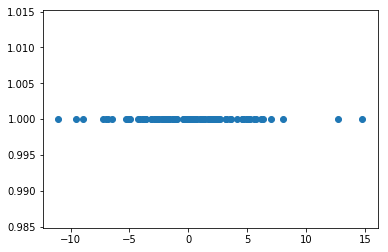

In [41]:
plt.scatter(list(energy_count.keys()),list(energy_count.values()))

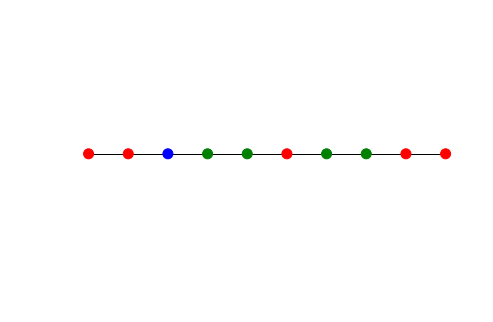

In [42]:
latt.draw()

In [46]:
plt.scatter?

In [ ]:
set.issubset?

In [ ]:
create?

In [ ]:
x = hashQobj

In [ ]:
hash(x)

In [ ]:
x = hashQobj(basis(2,0))

In [ ]:
hash(x)

In [ ]:
x

In [ ]:
x = {}

In [ ]:
len(x)

In [ ]:
basis(3,2)

In [ ]:
basis(2,1)

In [ ]:
np.ndarray?

In [ ]:
size = 4
arr = np.ndarray([size,size],dtype=Qobj)
arr

In [ ]:
type(arr[0][1])

In [46]:
latt = SquareLattice(size=50,periodic=True,hamiltonian='SpinGlass',ham_vars={'mu': 0, 'J_ij': 1})

NameError: name 'SquareLattice' is not defined

In [ ]:
latt.setRandomState()

print(latt.latticeEnergy())

latt.draw()

In [ ]:
energies = []
for i in range(500):
    latt.setRandomState()
    energies.append(latt.latticeEnergy())

In [ ]:
plt.hist(energies,bins=40)

In [ ]:
energy_set = set(energies)
for e in sorted(energy_set):
    print(e,'\t',energies.count(e))

In [ ]:
print?

In [ ]:
latt.hamiltonianVars

In [ ]:
x = {'i':1,'j':2}
x

In [ ]:
x.values()

In [ ]:
x.get?

In [ ]:
x.get('k')

In [ ]:
set(x.keys())

In [ ]:
y = {'j':1,'i':2}
y

In [ ]:
set(x.keys()) ^ set(y.keys())

In [ ]:
x.keys() == y.keys()

In [ ]:
nx.grid_2d_graph?

In [ ]:
# Dead code

#     def hamiltonianIsing(self,node):
#         energy = 0.
#         for neighbor in self.graph[node]:
#             tempstate = tensor(self.graph.node[node]['state'],self.graph.node[neighbor]['state'])
#             energy += expect(self.hamOp)
# #             energy += -self.J*self.graph.node[node]['state']*self.graph.node[neighbor]['state']
# #             energy += -self.mu*self.h*self.graph.node[node]['state']
#         return energy
    
# #     def hamiltonianSpinGlass(self,node):
# #         energy = 0.
# #         for neighbor in self.graph[node]:
# #             energy += 0
    
#     def hamiltonianHubbard(self,node):
#         energy = 0.
# #         for neighbor in self.graph[node]:
# #             energy += -self.J*
#         return 0
    
#     def hamiltonianHeisenberg(self,node):
#         energy = 0.
#         for neighbor in graph[node]:
#             energy += -self.J*self.graph.node[node]['state']*self.graph.node[neighbor]['state']
#             energy += -self.mu*self.h*self.graph.node[node]['state']
#         return 0
    
#     def hamiltonianNumberOp(self,node):
#         return 0
    

In [43]:
qutip.basis?

In [44]:
basis(2)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[ 1.]
 [ 0.]]

In [45]:
basis(2,0)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[ 1.]
 [ 0.]]

In [56]:
x = np.random.rand(2)
x

array([ 0.41139716,  0.27643556])

In [57]:
np.complex(*x)

(0.4113971596835897+0.27643555578673773j)

In [61]:
x = rand_ket(2)
x

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.46616392-0.42903079j]
 [ 0.49815588-0.59200043j]]

In [62]:
x.norm()

1.0

In [64]:
x = rand_ket(2)
y = rand_ket(2)
x,y

(Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[-0.51678963-0.53045802j]
  [-0.62540985+0.24577486j]],
 Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[-0.03347514+0.72673211j]
  [-0.58487564+0.35869254j]])

In [65]:
x.norm(),y.norm()

(0.9999999999999999, 1.0)